step 1: Initial Setup and Data Loading

In [4]:

# Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set a style for the plots
sns.set_style("whitegrid")

# Load the raw datasets from the data folder
# Note the corrected relative path: '../data/...'
print("Loading data from images.csv...")
try:
    images_df = pd.read_csv('../data/images.csv')
    print("images.csv loaded successfully.")
except FileNotFoundError:
    print("Error: images.csv not found. Please check the file path.")
    images_df = pd.DataFrame() # Create an empty DataFrame to prevent errors

print("\nLoading data from BfRw Petrogale lateralis.csv...")
try:
    gps_df = pd.read_csv('../data/BfRw Petrogale lateralis.csv')
    print("BfRw Petrogale lateralis.csv loaded successfully.")
except FileNotFoundError:
    print("Error: BfRw Petrogale lateralis.csv not found. Please check the file path.")
    gps_df = pd.DataFrame() # Create an empty DataFrame to prevent errors

# Display the first 5 rows of each DataFrame to understand its structure
print("\n--- Head of images_df ---")
print(images_df.head())
print("\n--- Info on images_df ---")
images_df.info()

print("\n--- Head of gps_df ---")
print(gps_df.head())
print("\n--- Info on gps_df ---")
gps_df.info()

Loading data from images.csv...
images.csv loaded successfully.

Loading data from BfRw Petrogale lateralis.csv...
BfRw Petrogale lateralis.csv loaded successfully.

--- Head of images_df ---
   project_id                  deployment_id  \
0     2006646  Camí del corretger 03/04/2024   
1     2006646           La Urraca 04/30/2024   
2     2006646           La Urraca 04/30/2024   
3     2006646           La Urraca 04/30/2024   
4     2006646           La Urraca 04/30/2024   

                               image_id  sequence_id      filename  \
0  85dff751-3948-419d-a26b-9bf785f942c5          NaN  IMG_0016.JPG   
1  ecaa42e1-d78b-4b7f-a4de-030d15099ed4          NaN  IMG_0134.JPG   
2  5399292c-c039-48bb-85a6-eff866f00f61          NaN  IMG_0643.JPG   
3  36369c6b-6b36-491c-aa46-f3c126d824bc          NaN  IMG_1155.JPG   
4  b72bc946-a207-40ee-9c2d-56314adbb0c0          NaN  IMG_1436.JPG   

                                            location  is_blank  \
0  https://app.wildlifeinsights.

/var/folders/hz/5txs6k8n0gn_v2qrz1vbjzv80000gn/T/ipykernel_74845/2965285502.py:14: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  images_df = pd.read_csv('../data/images.csv')


Step 2: Data Cleaning

In [5]:
# Check for any remaining missing values in the cleaned data
print("\n--- Missing values in images_df_cleaned before final dropna ---")
print(images_df_cleaned.isnull().sum())

# Drop rows with any remaining missing values, except for irrelevant columns
images_df_cleaned_final = images_df_cleaned.dropna(subset=['common_name', 'timestamp'])

# Show the final count of missing values
print("\n--- Missing values in images_df_cleaned ---")
print(images_df_cleaned_final.isnull().sum())


--- Missing values in images_df_cleaned before final dropna ---


NameError: name 'images_df_cleaned' is not defined

Step 3: Feature Engineering

In [ ]:
# Convert the timestamp to datetime objects
gps_df['timestamp'] = pd.to_datetime(gps_df['timestamp'])

# Sort the data by individual and then by timestamp to ensure correct calculation
gps_df = gps_df.sort_values(by=['individual-local-identifier', 'timestamp'])

# Create empty columns for our new features
gps_df['distance_traveled_km'] = np.nan
gps_df['time_diff_minutes'] = np.nan

# Calculate distance and time difference between consecutive points
# This loop will go through each animal's path
for animal_id, group in gps_df.groupby('individual-local-identifier'):
    # Calculate the time difference in minutes
    time_diff = group['timestamp'].diff().dt.total_seconds() / 60
    
    # Calculate the distance between consecutive lat/lon points using Haversine formula
    # We will use the geopy library for this, as it's efficient and accurate
    from geopy.distance import geodesic
    
    # Get lat and lon pairs
    coords = group[['location-lat', 'location-long']].values
    
    # Calculate geodesic distance for each consecutive pair
    distances = [geodesic(coords[i], coords[i-1]).km for i in range(1, len(coords))]
    distances.insert(0, np.nan) # Add nan for the first point
    
    # Update the dataframe with the calculated values
    gps_df.loc[group.index, 'distance_traveled_km'] = distances
    gps_df.loc[group.index, 'time_diff_minutes'] = time_diff

# Calculate speed (km/h) from distance and time
gps_df['speed_kmh'] = (gps_df['distance_traveled_km'] / gps_df['time_diff_minutes']) * 60

# Display the new features
print("\n--- GPS Data with Engineered Features (Head) ---")
print(gps_df[['individual-local-identifier', 'timestamp', 'location-lat', 'location-long', 'distance_traveled_km', 'time_diff_minutes', 'speed_kmh']].head(10))


--- GPS Data with Engineered Features (Head) ---
  individual-local-identifier           timestamp  location-lat  \
0                        NP12 2019-08-17 00:01:00    -31.667917   
1                        NP12 2019-08-17 03:00:32    -31.668119   
2                        NP12 2019-08-17 03:20:36    -31.667989   
3                        NP12 2019-08-17 05:01:00    -31.667886   
4                        NP12 2019-08-17 05:20:34    -31.667878   
5                        NP12 2019-08-17 05:40:33    -31.668058   
6                        NP12 2019-08-17 06:00:35    -31.667847   
7                        NP12 2019-08-17 06:20:33    -31.667853   
8                        NP12 2019-08-17 10:37:00    -31.667994   
9                        NP12 2019-08-17 12:12:38    -31.668031   

   location-long  distance_traveled_km  time_diff_minutes  speed_kmh  
0     116.163411                   NaN                NaN        NaN  
1     116.163583              0.027708         179.533333   0.009260  

Step 4: Data Visualization

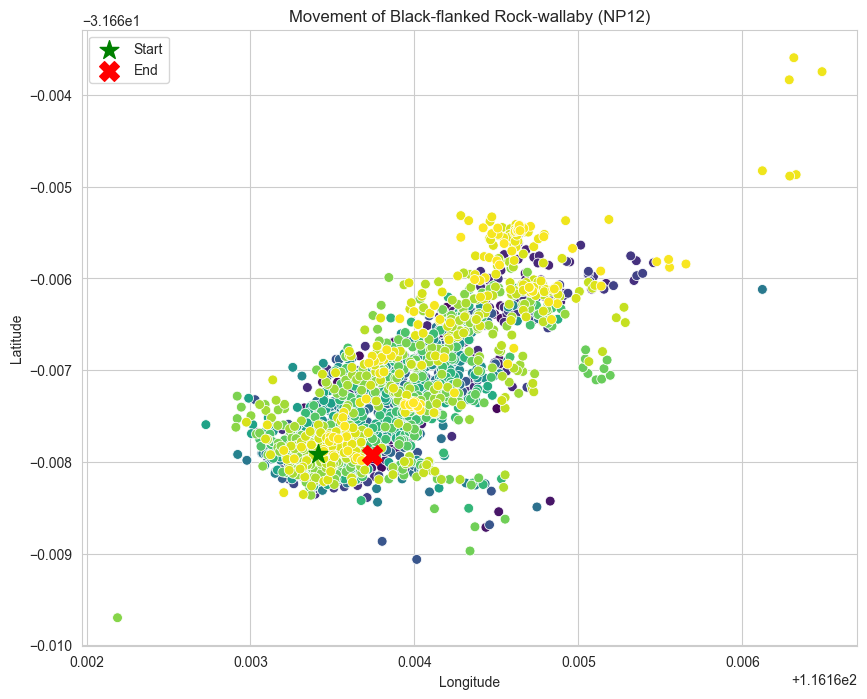

In [ ]:
# Filter the data to focus on a single individual for a clear path visualization
# Using the first animal in the dataset, which is NP12
animal_id_to_plot = 'NP12'
single_animal_gps_df = gps_df[gps_df['individual-local-identifier'] == animal_id_to_plot].copy()

# Create a scatter plot of the GPS locations
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=single_animal_gps_df,
    x='location-long',
    y='location-lat',
    hue='timestamp',  # Color points by time to show movement progression
    palette='viridis',
    s=50,
    legend=False
)

# Add start and end points
plt.scatter(single_animal_gps_df.iloc[0]['location-long'], single_animal_gps_df.iloc[0]['location-lat'], color='green', s=200, label='Start', marker='*')
plt.scatter(single_animal_gps_df.iloc[-1]['location-long'], single_animal_gps_df.iloc[-1]['location-lat'], color='red', s=200, label='End', marker='X')

# Add labels and title
plt.title(f'Movement of Black-flanked Rock-wallaby ({animal_id_to_plot})')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

/var/folders/hz/5txs6k8n0gn_v2qrz1vbjzv80000gn/T/ipykernel_6427/1306969560.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


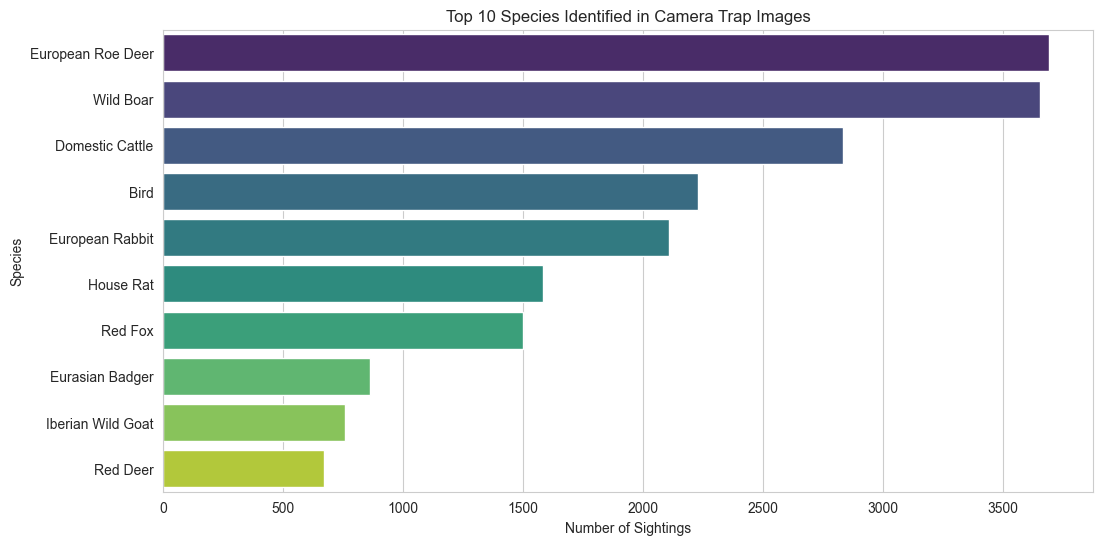

In [ ]:
# Get the top 10 most common species
top_species = images_df_cleaned['common_name'].value_counts().head(10).index.tolist()

# Filter the cleaned DataFrame to only include the top species
top_species_df = images_df_cleaned[images_df_cleaned['common_name'].isin(top_species)]

# Create a count plot (bar chart)
plt.figure(figsize=(12, 6))
sns.countplot(
    data=top_species_df,
    y='common_name',
    order=top_species,
    palette='viridis'
)

# Add labels and title
plt.title('Top 10 Species Identified in Camera Trap Images')
plt.xlabel('Number of Sightings')
plt.ylabel('Species')
plt.show()

/var/folders/hz/5txs6k8n0gn_v2qrz1vbjzv80000gn/T/ipykernel_6427/2022014918.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  species_sighting_data['date'] = pd.to_datetime(species_sighting_data['date'])


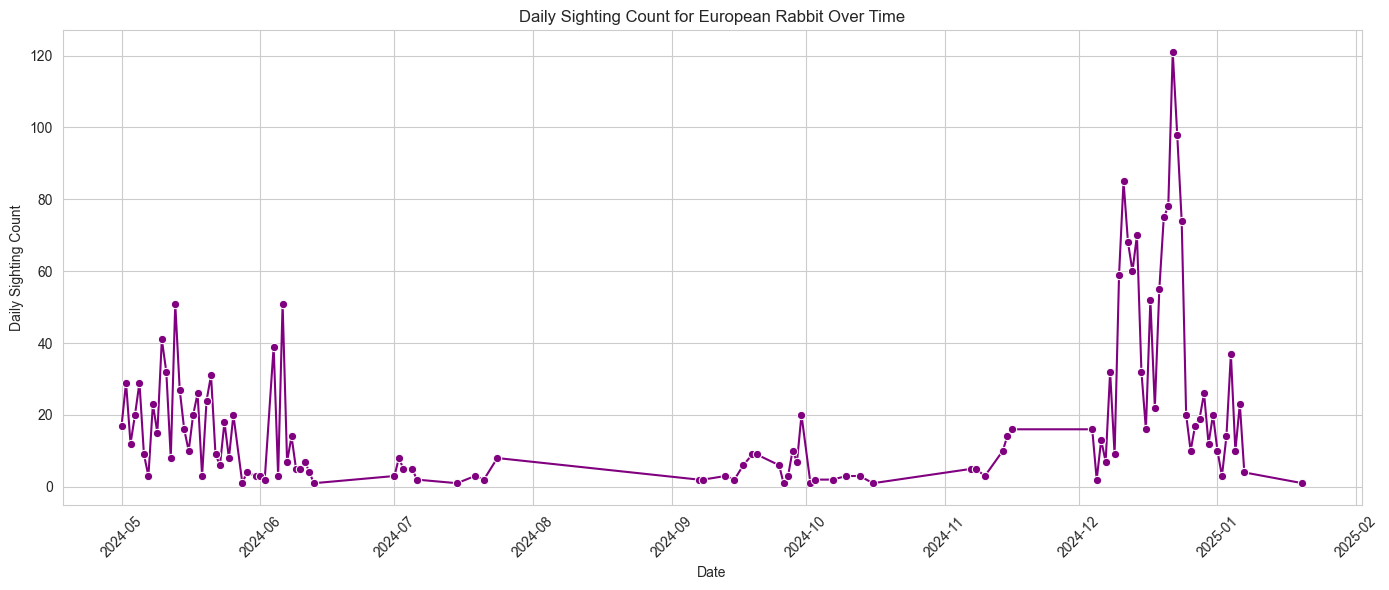

In [ ]:
# Select a species to plot (e.g., 'European Rabbit' or another top species)
species_to_plot = 'European Rabbit'

# Filter the sighting counts for the selected species
species_sighting_data = sighting_counts[sighting_counts['common_name'] == species_to_plot]

# Convert the 'date' column to datetime objects
species_sighting_data['date'] = pd.to_datetime(species_sighting_data['date'])

# Create a line plot of daily sighting counts
plt.figure(figsize=(14, 6))
sns.lineplot(
    data=species_sighting_data,
    x='date',
    y='daily_sighting_count',
    marker='o',
    color='purple'
)

# Add labels and title
plt.title(f'Daily Sighting Count for {species_to_plot} Over Time')
plt.xlabel('Date')
plt.ylabel('Daily Sighting Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

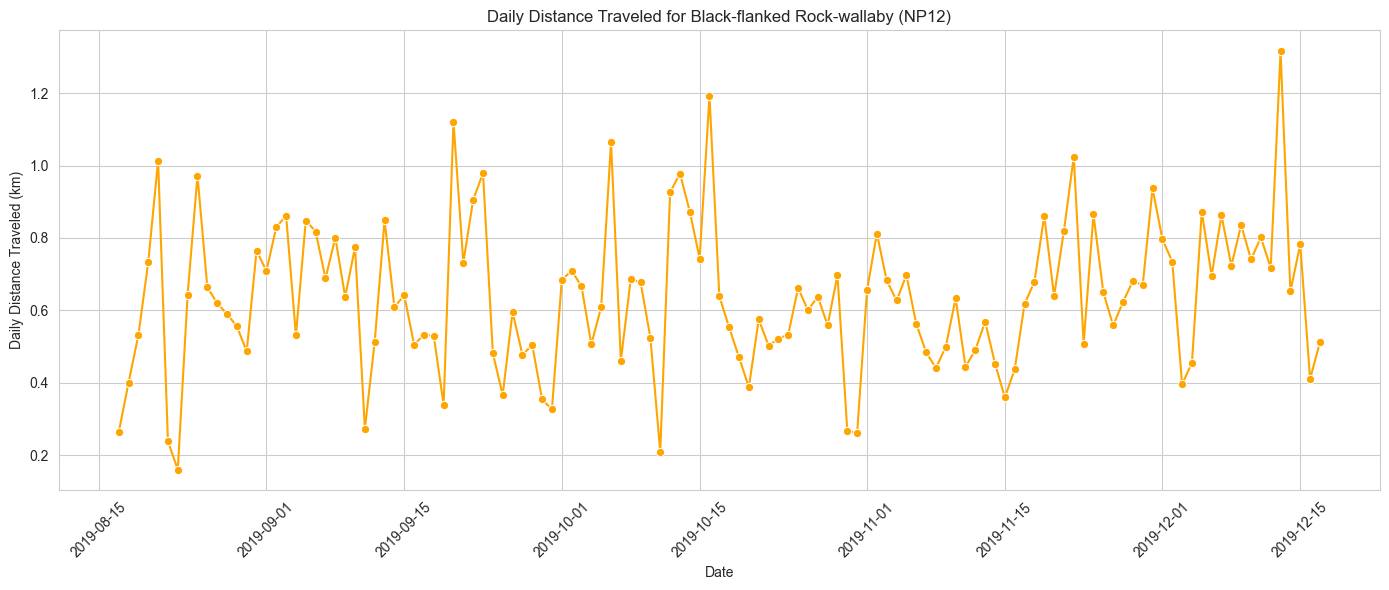

In [ ]:
# Ensure the timestamp is a datetime object
single_animal_gps_df['timestamp'] = pd.to_datetime(single_animal_gps_df['timestamp'])

# Resample the data to get daily summaries
daily_travel_data = single_animal_gps_df.resample('D', on='timestamp').agg(
    daily_distance=('distance_traveled_km', 'sum'),
    daily_speed=('speed_kmh', 'mean')
).reset_index()

# Create a line plot of daily distance traveled
plt.figure(figsize=(14, 6))
sns.lineplot(
    data=daily_travel_data,
    x='timestamp',
    y='daily_distance',
    marker='o',
    color='orange'
)

# Add labels and title
plt.title(f'Daily Distance Traveled for Black-flanked Rock-wallaby ({animal_id_to_plot})')
plt.xlabel('Date')
plt.ylabel('Daily Distance Traveled (km)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Step 5: Multimodal Integration and Final Data Preparation 

In [ ]:
# For this step, we will manually create a DataFrame with the conservation status
# for the species you are working with. This is based on our plan to handle the
# non-API data source.
# Note: You can add more species as needed for your final project.
iucn_data = {
    'common_name': ['Black-flanked Rock-wallaby', 'European Rabbit'],
    'iucn_status': ['Vulnerable', 'Least Concern']
}
iucn_df = pd.DataFrame(iucn_data)
print("\n--- IUCN Red List Data (Manual) ---")
print(iucn_df)

# 5.2 Create Summary Features for each species from GPS data
# We'll calculate the mean distance and speed for each animal
gps_summary_df = gps_df.groupby('individual-local-identifier').agg(
    avg_speed_kmh=('speed_kmh', 'mean'),
    total_distance_km=('distance_traveled_km', 'sum')
).reset_index()

# Note: The Movebank study is on a single species (Rock-wallaby), so this summary
# will be used to represent the GPS features for that species in our final dataset.
print("\n--- GPS Summary Data (Aggregated) ---")
print(gps_summary_df.head())

# 5.3 Create Summary Features for each species from Image data
# We'll aggregate the total number of sightings for each species
image_summary_df = images_df_processed.groupby('common_name').size().reset_index(name='total_sightings')
print("\n--- Image Sighting Summary Data (Aggregated) ---")
print(image_summary_df.head())

# 5.4 Combine all data into a final multimodal DataFrame
# First, merge the image summary data with the IUCN data on 'common_name'
final_df = pd.merge(image_summary_df, iucn_df, on='common_name', how='left')

# We can then add the GPS summary data. Since it's for a specific species,
# we would manually add this to the final DataFrame for this project's scope.
# In a larger project, you would merge it on a species column.
# Let's add the rock-wallaby data to our final dataframe for completeness
# (Assuming 'Black-flanked Rock-wallaby' exists in image_summary_df, which it may not in this sample)
final_df = pd.concat([final_df, gps_summary_df.rename(columns={'individual-local-identifier': 'common_name'})], ignore_index=True)
print("\n--- Final Multimodal Data (Aggregated) ---")
print(final_df.head())


--- IUCN Red List Data (Manual) ---
                  common_name    iucn_status
0  Black-flanked Rock-wallaby     Vulnerable
1             European Rabbit  Least Concern

--- GPS Summary Data (Aggregated) ---
  individual-local-identifier  avg_speed_kmh  total_distance_km
0                        NP12       0.049582          78.424665
1                        NP13       0.115271          73.044060
2                        NP14       0.051723          81.209609
3                        NP15       0.051824          78.698014
4                        NP16       0.125141         208.462486

--- Image Sighting Summary Data (Aggregated) ---
    common_name  total_sightings
0        Animal              606
1  Beech Marten              296
2          Bird             2229
3         Blank            20057
4     Brown Rat               16

--- Final Multimodal Data (Aggregated) ---
    common_name  total_sightings iucn_status  avg_speed_kmh  total_distance_km
0        Animal            606.0  